In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

data = pd.read_excel("WindPark VI.xlsx", index_col = 0, parse_dates = True)

# Multivariate Time Series Forecasting using Support Vector Regression

In [2]:
#a function to clean and prepare the data set
def clean_data(df_):
    
    df = df_.copy()
    
    all_cols = df.columns
    
    #creating a list for each category of variables
    active_power_avg = ['WTG 1-Active power avg [kW]', 'WTG 10-Active power avg [kW]', 
       'WTG 11-Active power avg [kW]', 'WTG 2-Active power avg [kW]', 
       'WTG 3-Active power avg [kW]', 'WTG 4-Active power avg [kW]',
       'WTG 5-Active power avg [kW]', 'WTG 6-Active power avg [kW]',
       'WTG 7-Active power avg [kW]', 'WTG 8-Active power avg [kW]',
       'WTG 9-Active power avg [kW]']

    wind_speed_avg = ['WTG 1-Wind speed avg [m/s]', 'WTG 10-Wind speed avg [m/s]', 
       'WTG 11-Wind speed avg [m/s]', 'WTG 2-Wind speed avg [m/s]', 
       'WTG 3-Wind speed avg [m/s]', 'WTG 4-Wind speed avg [m/s]',
       'WTG 5-Wind speed avg [m/s]', 'WTG 6-Wind speed avg [m/s]',
       'WTG 7-Wind speed avg [m/s]', 'WTG 8-Wind speed avg [m/s]',
       'WTG 9-Wind speed avg [m/s]']

    wind_direction_avg = ['WTG 1-Wind direction avg [°]', 'WTG 10-Wind direction avg [°]', 
       'WTG 11-Wind direction avg [°]', 'WTG 2-Wind direction avg [°]', 
       'WTG 3-Wind direction avg [°]', 'WTG 4-Wind direction avg [°]',
       'WTG 5-Wind direction avg [°]', 'WTG 6-Wind direction avg [°]',
       'WTG 7-Wind direction avg [°]', 'WTG 8-Wind direction avg [°]',
       'WTG 9-Wind direction avg [°]']

    ambient_temperature_avg = ['WTG 1-Ambient temperature avg [°C]', 'WTG 10-Ambient temperature avg [°C]', 
       'WTG 11-Ambient temperature avg [°C]', 'WTG 2-Ambient temperature avg [°C]', 
       'WTG 3-Ambient temperature avg [°C]', 'WTG 4-Ambient temperature avg [°C]',
       'WTG 5-Ambient temperature avg [°C]', 'WTG 6-Ambient temperature avg [°C]',
       'WTG 7-Ambient temperature avg [°C]', 'WTG 8-Ambient temperature avg [°C]',
       'WTG 9-Ambient temperature avg [°C]']
    
    #using the interpolate function to remove null values
    df = df.interpolate()
    
    #setting boundaries for the values of each category of variables, with the clip function
    df[active_power_avg] = df[active_power_avg].clip(0, 850)
    df[wind_speed_avg] = df[wind_speed_avg].clip(0, 30)
    df[wind_direction_avg] = df[wind_direction_avg].clip(0, 360)
    df[ambient_temperature_avg] = df[ambient_temperature_avg].clip(-10, 40)
    
    #creating new columns with the sum or average, depending on the category of variables
    df["Total Active power avg [kW]"] = df[active_power_avg].sum(axis = 1)
    df["Wind speed avg [m/s]"] = df[wind_speed_avg].mean(axis = 1)
    df["Ambient temperature avg [°C]"] = df[ambient_temperature_avg].mean(axis = 1)
    df["Wind direction avg [°]"] = df[wind_direction_avg].mean(axis = 1)
    
    #dropping the original columns
    df.drop(all_cols, axis = 1, inplace = True)
    
    #setting an hourly frequency to the time series
    df = df.resample('H').mean()
    
    return df

In [3]:
data = clean_data(data)
data.head()

,Total Active power avg [kW],Wind speed avg [m/s],Ambient temperature avg [°C],Wind direction avg [°]
TimeStamp,,,,
2016-01-01 00:00:00,1372.666667,5.936364,-4.060606,32.151515
2016-01-01 01:00:00,664.116667,4.743939,-4.045455,26.448485
2016-01-01 02:00:00,13.583333,2.871212,-3.757576,67.734848
2016-01-01 03:00:00,176.716667,3.675758,-3.939394,60.374242
2016-01-01 04:00:00,64.116667,3.280303,-3.863636,69.712121


First of all, we clean the data set, using the `clean_data()` function, which is based on what we did on the Exploratory Data Analysis part of the project.

In [4]:
def time_lags(df_, steps):
    
    df = df_.copy()
    cols = df.columns
        
    for col in cols:
        for i in range(1, steps + 1):
            df[col + f" (t-{str(i)})"] = df[col].shift(i)
            
    df.dropna(inplace = True)        
            
    return df

Supervised learning algorithms can't be used in time series forecasting problems, without modifying the data somehow. the `time_lags()` function adds a number of time lag columns on the data set. Those time lag values will be the features of the supervised learning algorithm. This is known as the sliding window method.

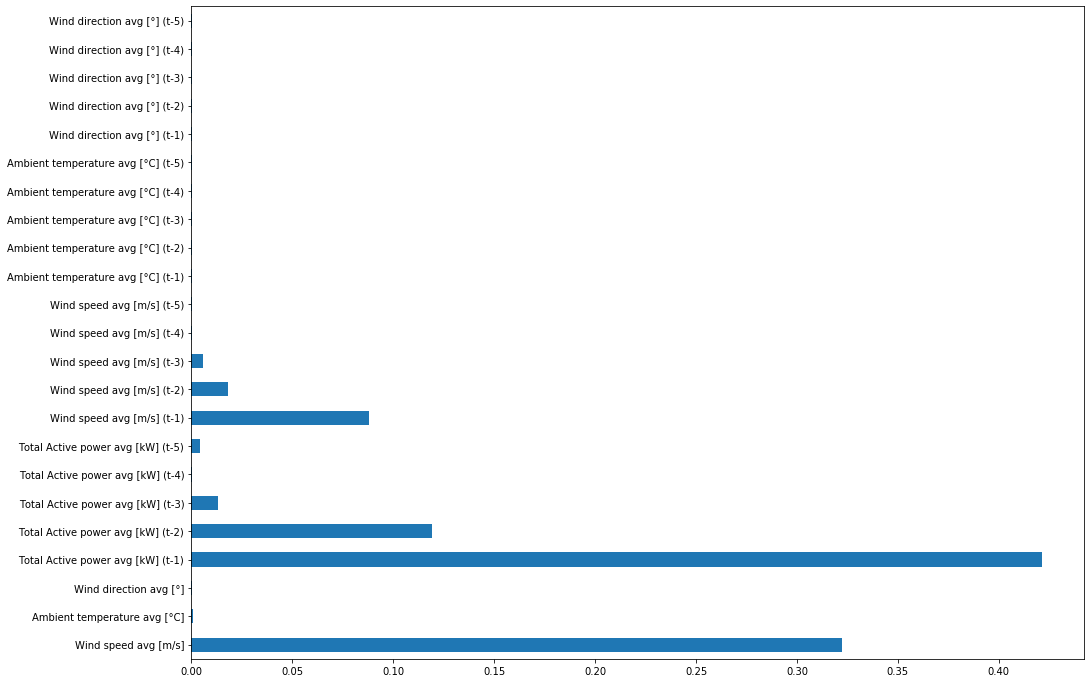

In [5]:
from sklearn.ensemble import ExtraTreesRegressor

data_lags = time_lags(data, 5)

x = data_lags.iloc[: , 1:]
y = data_lags.iloc[: , 0]

model = ExtraTreesRegressor(n_estimators = 100, n_jobs=-1)
model.fit(x, y)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
plt.figure(figsize=(16,12))
feat_importances.plot(kind='barh')

We fitted an Extra Trees model to our data, to understand which features are the most important. As we expected, based on the exploratory data analysis, wind speed is the most important feature. On the other hand, wind direction and ambient temperature don't contribute any significant information, and will not be included in the forecasting model. We can also see that the importance of the time lags decreases, for every step taken back in time.

In [6]:
lags = 5
cols = ["Total Active power avg [kW]", "Wind speed avg [m/s]"]

cols_arrange = ['Total Active power avg [kW]', 'Total Active power avg [kW] (t-1)',
       'Total Active power avg [kW] (t-2)', 'Total Active power avg [kW] (t-3)',
       'Total Active power avg [kW] (t-4)', 'Total Active power avg [kW] (t-5)',
       'Wind speed avg [m/s]', 'Wind speed avg [m/s] (t-1)',
       'Wind speed avg [m/s] (t-2)', 'Wind speed avg [m/s] (t-3)',
       'Wind speed avg [m/s] (t-4)', 'Wind speed avg [m/s] (t-5)']

#creating a univariate time series forecasting model for the wind speed variable
#to use its predictions as input for the multivariate time series forecasting model

#creating the time lags and splitting the data to train and test sets
data_wind = data.loc[:, ["Wind speed avg [m/s]"]]
data_wind = time_lags(data_wind, lags)
train_wind, test_wind = data_wind["2016":"2017"], data_wind["2018"]

train_x_wind = train_wind.iloc[:, 1:].values
train_y_wind = train_wind.iloc[:, 0].values

test_x_wind = test_wind.iloc[:, 1:].values
test_y_wind = test_wind.iloc[:, 0].values

#scaling the features of the model for better performance and accuracy
scaler_x_wind = StandardScaler()
train_x_wind = scaler_x_wind.fit_transform(train_x_wind)
test_x_wind = scaler_x_wind.transform(test_x_wind)
scaler_y_wind = StandardScaler()
scaler_y_wind.fit(train_y_wind.reshape(-1,1))

#fitting a Support Vector Regression model to the univariate series data
model_wind = LinearSVR(C=10, max_iter=10000)
model_wind.fit(train_x_wind, train_y_wind)

#creating the multivariate time series forecasting model
#that will use the wind speed forecasting model predictions as input

#creating the time lags and splitting the data to train and test sets
data_power = time_lags(data[cols], lags)
data_power = data_power[cols_arrange]
train_power, test_power = data_power["2016":"2017"], data_power["2018"]

train_x_power = train_power.iloc[:, 1:].values
train_y_power = train_power.iloc[:, 0].values
    
test_x_power = test_power.iloc[:, 1:].values
test_y_power = test_power.iloc[:, 0].values

#scaling the features of the model for better performance and accuracy
scaler_x_power = StandardScaler()
train_x_power = scaler_x_power.fit_transform(train_x_power)
test_x_power = scaler_x_power.transform(test_x_power)
scaler_y_power = StandardScaler()
scaler_y_power.fit(train_y_power.reshape(-1,1))

#fitting a Support Vector Regression model to the multivariate series data
model_power = LinearSVR(C=10, max_iter=10000)
model_power.fit(train_x_power, train_y_power)


LinearSVR(C=10, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0)

We fitted two different Support Vector Regression models that will interact with each other. The first model is a univariate forecasting model of the wind speed variable, with 5 time lags. This was necessary, because the multivariate model of active power needs future values of wind speed to make a prediction, thus we need to predict those values on a seperate model, to use them as input. After that we also created the base multivariate and multi-step forecasting model for active power.

In [7]:
steps = 36
stop = len(test_x_power) - steps
rss = np.zeros(steps)
count = 0

#creating multi-step forecasts for the test data set
#the forecast horizon is 36 hours.
for i in range(0, stop, steps):
    arr_predict = test_x_power[i]
    arr_power = arr_predict[0:5]
    arr_wind = arr_predict[6:]

    for j in range(0, steps):
        
        #we make a prediction for the value of wind speed
        p_wind = model_wind.predict([arr_wind])
        p_wind = scaler_y_wind.transform([p_wind]).reshape(1,)
        
        #the prediction of the univariate model for wind speed
        #is used as input for the multivariate model
        concat = np.concatenate( (arr_power, p_wind, arr_wind) ) 
        p_power = model_power.predict([concat])

        #the time lags are shifted to the right
        #to be used as input for the next time step
        arr_wind = np.delete(arr_wind, -1)
        arr_wind = np.insert(arr_wind, 0, p_wind)
        
        arr_power = np.delete(arr_power, -1)
        arr_power = np.insert(arr_power, 0, scaler_y_power.transform([p_power]))
        
        #we calculate the residual for each prediction
        #and add it to the residual sum of squares, for each time step
        residual = test_y_power[j+i] - p_power
        rss[j] += pow(residual, 2)
          
    count += 1

#we calculate the RMSE for each time step
rmse = np.sqrt(rss/count)

Our goal is to test the accuracy of our model, by making forecast with 36-hour horizons on the test data set (about 15% of the total values). To achieve that, the univariate model for wind speed is making a prediction, which is used as input for the multivariate model. After that, the multivariate model is making itself a prediction for the active power value. The time lag values are then shifted to the right, to be used as input for the next time step. Last, we calculate the residuals and the RMSE for each time step.

In [8]:
for i in range(len(rmse)):
    print(f'time step: {i} - RMSE: {rmse[i]}')

time step: 0 - RMSE: 977.4172828950898
time step: 1 - RMSE: 1312.572561131081
time step: 2 - RMSE: 1606.1353433855825
time step: 3 - RMSE: 1647.7622313669638
time step: 4 - RMSE: 1887.8536236692673
time step: 5 - RMSE: 2244.426442964676
time step: 6 - RMSE: 2395.9338383334207
time step: 7 - RMSE: 2246.7955077837682
time step: 8 - RMSE: 2696.7507965593572
time step: 9 - RMSE: 2657.867575122072
time step: 10 - RMSE: 2754.3817554261477
time step: 11 - RMSE: 2846.621171999627
time step: 12 - RMSE: 2718.8342010645947
time step: 13 - RMSE: 2788.347265781318
time step: 14 - RMSE: 2728.443044025831
time step: 15 - RMSE: 2588.634409644026
time step: 16 - RMSE: 2776.884325362923
time step: 17 - RMSE: 2689.471665975812
time step: 18 - RMSE: 2589.0759933513013
time step: 19 - RMSE: 2582.7656362551897
time step: 20 - RMSE: 2733.2744541548727
time step: 21 - RMSE: 2988.199749174284
time step: 22 - RMSE: 3067.6529985865777
time step: 23 - RMSE: 2890.0605020009816
time step: 24 - RMSE: 2740.8938544577

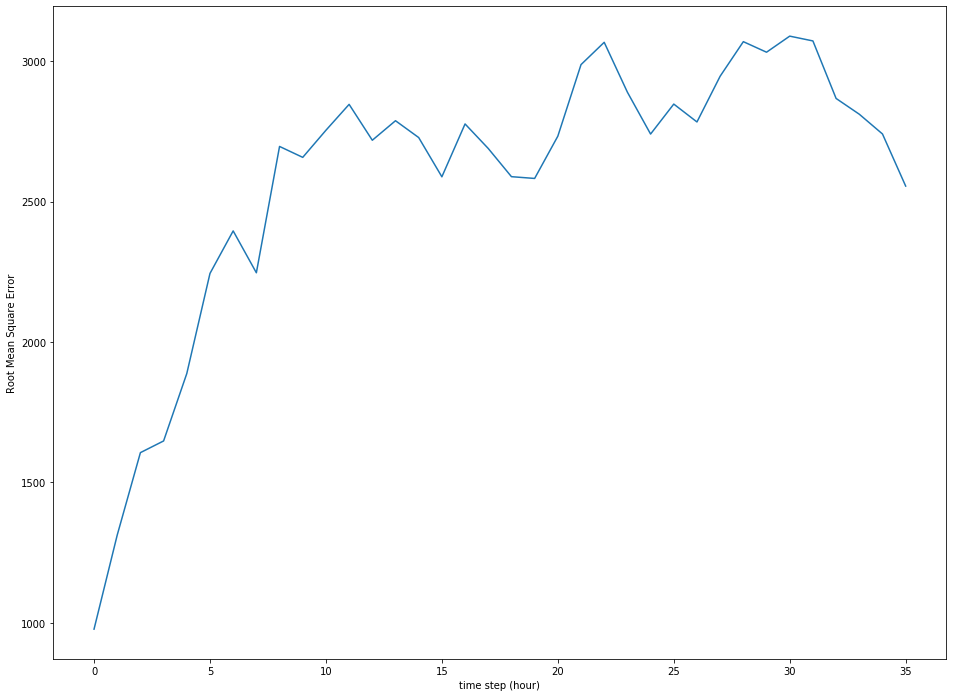

In [9]:
plt.figure(figsize=(16,12))
plt.ylabel("Root Mean Square Error")
plt.xlabel("time step (hour)")
plt.plot(rmse)

As we can see, the forecasting model is fairly accurate on the first time steps, but the RMSE gets signficantly higher after that.